# Time Series Forecasting with TensorFlow

### Contents of this notebook
  * Get the time series data
    * Load the time series data using Pandas/Python,s CSV module
  * Format data for a time series problem
    * Creating training and test sets (the wrong way)
    * Creating training and test sets (the right way)
    * Visualizing time series data
    * Turning time series data into a supervised learning problem (windowing)
    * Preparing univariate and multivariate
  * Evaluating a time series forecasting model
  * Setting up a series of deep learning modelling experiments
    * Dense (fully-connected) networks
    * Sequence models (LSTM and 1D CNN)
    * Ensembling (combining multiple models together)
    * Multivariate models
    * Replicating the N-BEATS algorithm using TensorFlow layer subclassing
  * Creating a model checkpoint to save the best performing model during training
  * Making predictions (forecasts) with a time series model
  * Creating prediction intervals for the time series model forecasts
  * Discussing two different types of uncertainity in machine learning (data uncertainity and model uncertainity)
  * Demonstrating why forecasting in an open system is BS (the turkey problem)

### Check for GPU

In [2]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-14f6e639-45e5-4ae5-a4fa-c13705bbd2d6)


## Get data

In [3]:
# Download Bitcoin historical data from GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-02-18 17:21:51--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.008s  

2023-02-18 17:21:51 (20.6 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



### Importing time series data with pandas

In [4]:
# Import with pandas
import pandas as pd
import numpy as np
df = pd.read_csv('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',
                 parse_dates=['Date'],
                 index_col=['Date'])

In [5]:
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [7]:
df.shape

(2787, 5)

In [8]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={'Closing Price (USD)': 'Price'})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


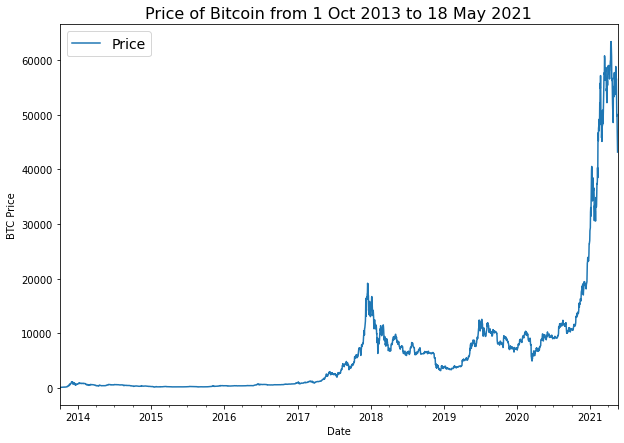

In [9]:
# Visulaizing data
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel('BTC Price')
plt.title('Price of Bitcoin from 1 Oct 2013 to 18 May 2021', fontsize=16)
plt.legend(fontsize=14)

### Importing time series data with Python's CSV module

In [10]:
# Importing and formatting historical Bitcoin data with Python

import csv
from datetime import datetime

timesteps = []
btc_price = []
with open('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv') as f:
  csv_reader = csv.reader(f, delimiter=',')
  next(csv_reader)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))
    btc_price.append(float(line[2]))

# View first 10 of each

timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Text(0.5, 0, 'Date')

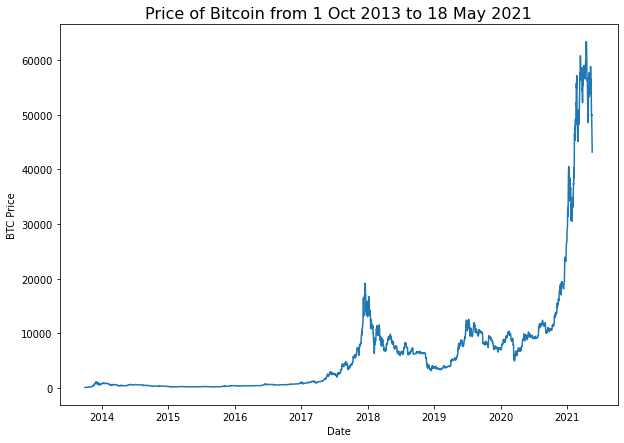

In [11]:
# Plot from CSV
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.ylabel('BTC Price')
plt.title('Price of Bitcoin from 1 Oct 2013 to 18 May 2021', fontsize=16)
plt.xlabel('Date')

## Formatting data for time series problem

### Creating train and test sets for time series data (the wrong way)

In [12]:
# Get Bitcoin date array

timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [13]:
# Wrong way to make train test split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

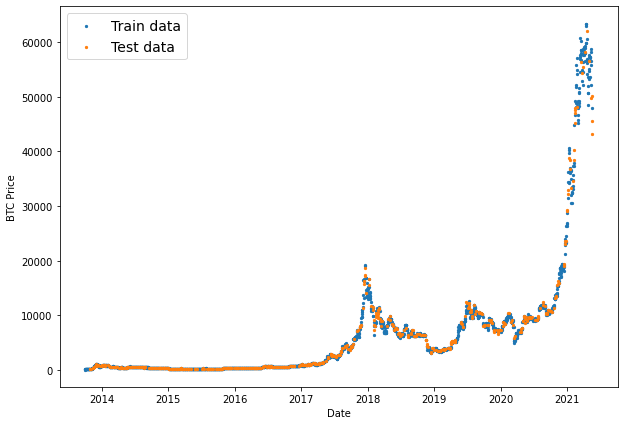

In [14]:
# Plotting wrong train and test splits

plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=14)
plt.show()

### Creating train and test sets for time series data (the right way)

In [15]:
split_size = int(0.8 * len(prices))

X_train, y_train = timesteps[0:split_size], prices[:split_size]

X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

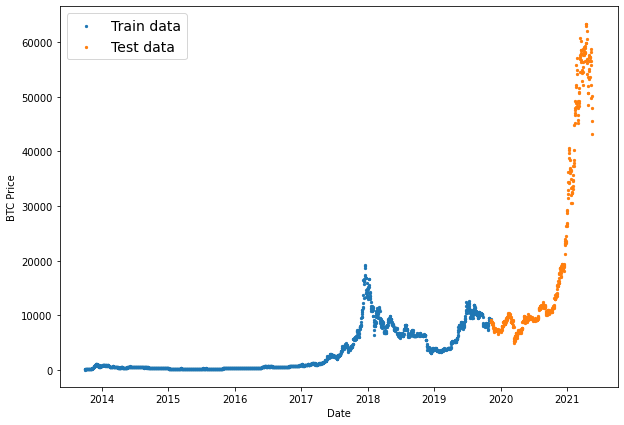

In [16]:
# Plot correctly made splits

plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=14)
plt.show()

### Creating a plotting function

In [17]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel('Time')
  plt.ylabel('BTC Price')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True) 

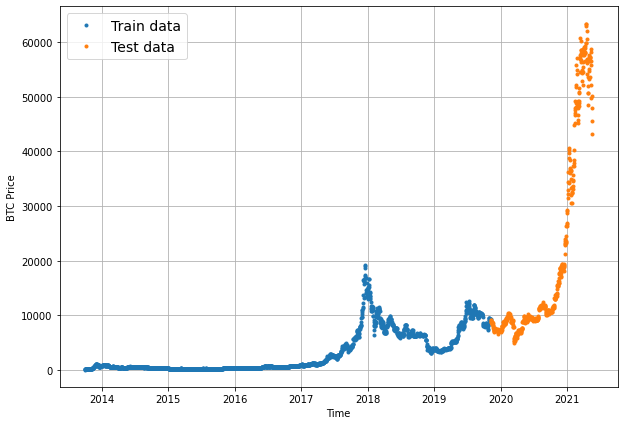

In [18]:
# Try out our plotting function

plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')

## Modelling Experiments

### Model 0: Naive Forecast (baseline)

In [19]:
# Create a naive forecast

naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

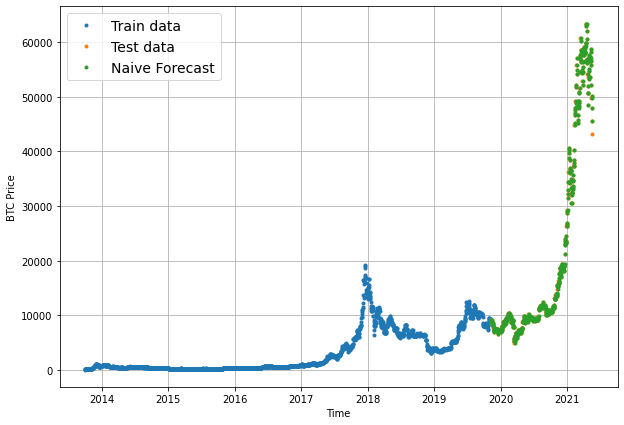

In [20]:
# Plot naive forecast

plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, label='Naive Forecast')

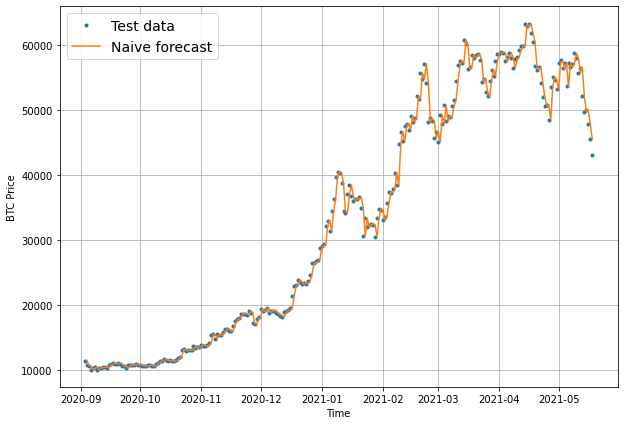

In [21]:
# Zooming in the plot

plt.figure(figsize=(10, 7))
offset = 300
plot_time_series(timesteps=X_test, values=y_test, start=offset, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=offset, format='-', label='Naive forecast')


### Evaluating a time series model

In [22]:
import tensorflow as tf

In [23]:
# Create a function to calculate MASE (mean absolute scaled error)

def mean_absolute_scaled_error(y_true, y_pred):
  
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))
  
  return mae/mae_naive_no_season

In [24]:
# Create a function to calculate results (predictions)

def evaluate_preds(y_true, y_pred):

  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [25]:
naive_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

### Other models/libraries for time series forecasting
  * Moving average
  * ARIMA (AutoRegression Integrated Moving Average)
  * Sktime (Scikit-learn for time series)
  * TensorFlow Decision Forecasts (random forest, gradient boosting trees)
  * Facebook Kats (purpose built forecasting and time series analysis library by facebook)
  * LinkedIn Greykite (flexible, intuitive and fast forecasts)


### Windowing dataset

In [26]:
HORIZON = 1           # Predict 1 step at a time
WINDOW_SIZE = 7       # Use a week worth of timestamps to predict the horizon

In [27]:
# Create a function to label windowed data

def get_labelled_windows(x, horizon=1):

  return x[:,:-horizon], x[:,-horizon:]

In [28]:
# Test out the window labelling function

test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {test_window} -> Label: {test_label}")

Window: [[1 2 3 4 5 6 7]] -> Label: [[8]]


In [29]:
# Create a function to view NumPy arrays as windows

def make_windows(x, window_size=7, horizon=1):

  # 1. Create a window of specific window size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for zero indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size+horizon-1)), axis=0).T

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [30]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [31]:
# View the first three windows/labels

for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


### Turning windows into training and test sets

In [32]:
# Make the train test split

def make_train_test_split(windows, labels, test_split=0.2):

  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [33]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [34]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

### Make modelling checkpoint

In [35]:
import os

# Create a function ti implement model checkpoint callback with a specific filename

def create_model_checkpoint(model_name, save_path="model_experiments"):
  
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

### Model 1: Dense model (window = 7, horizon = 1)

In [36]:
import tensorflow as tf
from tensorflow.keras import layers

# Set seed
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_1_dense")

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

# Fit model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
15/18 [========================>.....] - ETA: 0s - loss: 2984.9275 - mae: 2984.9275  

18/18 [==============================] - 8s 74ms/step - loss: 2792.8274 - mae: 2792.8274 - val_loss: 6771.1440 - val_mae: 6771.1440
Epoch 2/100
15/18 [========================>.....] - ETA: 0s - loss: 453.0300 - mae: 453.0300

18/18 [==============================] - 1s 44ms/step - loss: 437.4053 - mae: 437.4053 - val_loss: 1243.5789 - val_mae: 1243.5789
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 164.5437 - mae: 164.5437

18/18 [==============================] - 0s 27ms/step - loss: 204.0314 - mae: 204.0314 - val_loss: 1005.4094 - val_mae: 1005.4094
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 245.0219 - mae: 245.0219

18/18 [==============================] - 0s 27ms/step - loss: 178.4635 - mae: 178.4635 - val_loss: 962.5963 - val_mae: 962.5963
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 196.0441 - mae: 196.0441

18/18 [==============================] - 0s 26ms/step - loss: 168.5961 - mae: 168.5961 - val_loss: 923.7477 - val_mae: 923.7477
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 123.2668 - mae: 123.2668

18/18 [==============================] - 1s 34ms/step - loss: 165.4332 - mae: 165.4332 - val_loss: 922.6266 - val_mae: 922.6266
Epoch 7/100
16/18 [=========================>....] - ETA: 0s - loss: 167.0779 - mae: 167.0779

18/18 [==============================] - 1s 39ms/step - loss: 162.2077 - mae: 162.2077 - val_loss: 911.4918 - val_mae: 911.4918
Epoch 8/100
15/18 [========================>.....] - ETA: 0s - loss: 157.1893 - mae: 157.1893

18/18 [==============================] - 1s 39ms/step - loss: 160.7573 - mae: 160.7573 - val_loss: 888.7836 - val_mae: 888.7836
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 157.8822 - mae: 157.8822 - val_loss: 894.6210 - val_mae: 894.6210
Epoch 10/100
16/18 [=========================>....] - ETA: 0s - loss: 153.4341 - mae: 153.4341

18/18 [==============================] - 1s 32ms/step - loss: 155.5412 - mae: 155.5412 - val_loss: 867.1402 - val_mae: 867.1402
Epoch 11/100
18/18 [==============================] - ETA: 0s - loss: 153.8750 - mae: 153.8750

18/18 [==============================] - 0s 27ms/step - loss: 153.8750 - mae: 153.8750 - val_loss: 856.8818 - val_mae: 856.8818
Epoch 12/100
18/18 [==============================] - 0s 5ms/step - loss: 151.5387 - mae: 151.5387 - val_loss: 908.5610 - val_mae: 908.5610
Epoch 13/100
 1/18 [>.............................] - ETA: 0s - loss: 120.5249 - mae: 120.5249

18/18 [==============================] - 1s 37ms/step - loss: 149.3720 - mae: 149.3720 - val_loss: 835.9690 - val_mae: 835.9690
Epoch 14/100
18/18 [==============================] - 0s 6ms/step - loss: 145.8603 - mae: 145.8603 - val_loss: 852.0877 - val_mae: 852.0877
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 148.6620 - mae: 148.6620

18/18 [==============================] - 0s 25ms/step - loss: 145.5624 - mae: 145.5624 - val_loss: 810.4448 - val_mae: 810.4448
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 127.6625 - mae: 127.6625

18/18 [==============================] - 0s 25ms/step - loss: 142.0930 - mae: 142.0930 - val_loss: 789.5052 - val_mae: 789.5052
Epoch 17/100
16/18 [=========================>....] - ETA: 0s - loss: 138.8366 - mae: 138.8366

18/18 [==============================] - 0s 27ms/step - loss: 140.3846 - mae: 140.3846 - val_loss: 785.3118 - val_mae: 785.3118
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 149.8324 - mae: 149.8324

18/18 [==============================] - 0s 26ms/step - loss: 138.9895 - mae: 138.9895 - val_loss: 783.1664 - val_mae: 783.1664
Epoch 19/100
 1/18 [>.............................] - ETA: 0s - loss: 82.9654 - mae: 82.9654

18/18 [==============================] - 0s 26ms/step - loss: 137.8614 - mae: 137.8614 - val_loss: 755.3826 - val_mae: 755.3826
Epoch 20/100
18/18 [==============================] - 0s 5ms/step - loss: 139.8889 - mae: 139.8889 - val_loss: 839.7839 - val_mae: 839.7839
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 205.2356 - mae: 205.2356

18/18 [==============================] - 0s 26ms/step - loss: 138.9848 - mae: 138.9848 - val_loss: 737.3987 - val_mae: 737.3987
Epoch 22/100
 1/18 [>.............................] - ETA: 0s - loss: 189.4345 - mae: 189.4345

18/18 [==============================] - 0s 27ms/step - loss: 136.9064 - mae: 136.9064 - val_loss: 731.9457 - val_mae: 731.9457
Epoch 23/100
18/18 [==============================] - 0s 5ms/step - loss: 132.9069 - mae: 132.9069 - val_loss: 769.0769 - val_mae: 769.0769
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 149.4797 - mae: 149.4797

18/18 [==============================] - 0s 26ms/step - loss: 132.8478 - mae: 132.8478 - val_loss: 724.8142 - val_mae: 724.8142
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 142.4670 - mae: 142.4670

18/18 [==============================] - 0s 27ms/step - loss: 131.3701 - mae: 131.3701 - val_loss: 706.4943 - val_mae: 706.4943
Epoch 26/100
 1/18 [>.............................] - ETA: 0s - loss: 134.6149 - mae: 134.6149

18/18 [==============================] - 0s 25ms/step - loss: 128.0918 - mae: 128.0918 - val_loss: 697.7194 - val_mae: 697.7194
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 184.1137 - mae: 184.1137

18/18 [==============================] - 0s 26ms/step - loss: 127.3713 - mae: 127.3713 - val_loss: 697.0356 - val_mae: 697.0356
Epoch 28/100
18/18 [==============================] - ETA: 0s - loss: 125.9728 - mae: 125.9728

18/18 [==============================] - 0s 27ms/step - loss: 125.9728 - mae: 125.9728 - val_loss: 684.5853 - val_mae: 684.5853
Epoch 29/100
18/18 [==============================] - 0s 4ms/step - loss: 124.8464 - mae: 124.8464 - val_loss: 685.1221 - val_mae: 685.1221
Epoch 30/100
18/18 [==============================] - 0s 5ms/step - loss: 127.9214 - mae: 127.9214 - val_loss: 734.0993 - val_mae: 734.0993
Epoch 31/100
18/18 [==============================] - 0s 4ms/step - loss: 137.4369 - mae: 137.4369 - val_loss: 802.4418 - val_mae: 802.4418
Epoch 32/100
 1/18 [>.............................] - ETA: 0s - loss: 134.4786 - mae: 134.4786

18/18 [==============================] - 0s 26ms/step - loss: 135.8405 - mae: 135.8405 - val_loss: 666.8770 - val_mae: 666.8770
Epoch 33/100
18/18 [==============================] - 0s 5ms/step - loss: 133.3409 - mae: 133.3409 - val_loss: 703.8083 - val_mae: 703.8083
Epoch 34/100
18/18 [==============================] - 0s 5ms/step - loss: 123.7323 - mae: 123.7323 - val_loss: 683.8082 - val_mae: 683.8082
Epoch 35/100
 1/18 [>.............................] - ETA: 0s - loss: 123.0161 - mae: 123.0161

18/18 [==============================] - 0s 26ms/step - loss: 121.5584 - mae: 121.5584 - val_loss: 651.8752 - val_mae: 651.8752
Epoch 36/100
18/18 [==============================] - 0s 6ms/step - loss: 123.1017 - mae: 123.1017 - val_loss: 699.9052 - val_mae: 699.9052
Epoch 37/100
 1/18 [>.............................] - ETA: 0s - loss: 151.9223 - mae: 151.9223

18/18 [==============================] - 1s 39ms/step - loss: 121.1165 - mae: 121.1165 - val_loss: 643.9358 - val_mae: 643.9358
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 108.6671 - mae: 108.6671

18/18 [==============================] - 0s 27ms/step - loss: 119.2574 - mae: 119.2574 - val_loss: 639.9243 - val_mae: 639.9243
Epoch 39/100
 1/18 [>.............................] - ETA: 0s - loss: 134.2945 - mae: 134.2945

18/18 [==============================] - 1s 34ms/step - loss: 118.0552 - mae: 118.0552 - val_loss: 636.9905 - val_mae: 636.9905
Epoch 40/100
18/18 [==============================] - 0s 7ms/step - loss: 118.4838 - mae: 118.4838 - val_loss: 640.7458 - val_mae: 640.7458
Epoch 41/100
15/18 [========================>.....] - ETA: 0s - loss: 125.2561 - mae: 125.2561

18/18 [==============================] - 1s 39ms/step - loss: 121.0080 - mae: 121.0080 - val_loss: 630.4504 - val_mae: 630.4504
Epoch 42/100
18/18 [==============================] - 0s 7ms/step - loss: 121.0474 - mae: 121.0474 - val_loss: 633.1525 - val_mae: 633.1525
Epoch 43/100
18/18 [==============================] - 0s 6ms/step - loss: 118.3213 - mae: 118.3213 - val_loss: 653.6290 - val_mae: 653.6290
Epoch 44/100
18/18 [==============================] - 0s 7ms/step - loss: 118.3940 - mae: 118.3940 - val_loss: 630.8380 - val_mae: 630.8380
Epoch 45/100
13/18 [====================>.........] - ETA: 0s - loss: 117.9882 - mae: 117.9882

18/18 [==============================] - 1s 36ms/step - loss: 118.5964 - mae: 118.5964 - val_loss: 621.2770 - val_mae: 621.2770
Epoch 46/100
 1/18 [>.............................] - ETA: 0s - loss: 90.0629 - mae: 90.0629

18/18 [==============================] - 0s 25ms/step - loss: 116.1819 - mae: 116.1819 - val_loss: 620.5330 - val_mae: 620.5330
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 123.3558 - mae: 123.3558 - val_loss: 657.0375 - val_mae: 657.0375
Epoch 48/100
18/18 [==============================] - 0s 4ms/step - loss: 119.7902 - mae: 119.7902 - val_loss: 704.0484 - val_mae: 704.0484
Epoch 49/100
18/18 [==============================] - 0s 4ms/step - loss: 117.9071 - mae: 117.9071 - val_loss: 624.3547 - val_mae: 624.3547
Epoch 50/100
 1/18 [>.............................] - ETA: 0s - loss: 134.3234 - mae: 134.3234

18/18 [==============================] - 0s 26ms/step - loss: 114.7172 - mae: 114.7172 - val_loss: 610.8628 - val_mae: 610.8628
Epoch 51/100
18/18 [==============================] - 0s 4ms/step - loss: 113.9080 - mae: 113.9080 - val_loss: 623.8072 - val_mae: 623.8072
Epoch 52/100
18/18 [==============================] - 0s 4ms/step - loss: 116.1522 - mae: 116.1522 - val_loss: 611.8519 - val_mae: 611.8519
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 115.9080 - mae: 115.9080 - val_loss: 624.1317 - val_mae: 624.1317
Epoch 54/100
18/18 [==============================] - 0s 5ms/step - loss: 115.0345 - mae: 115.0345 - val_loss: 683.2748 - val_mae: 683.2748
Epoch 55/100
 1/18 [>.............................] - ETA: 0s - loss: 141.6559 - mae: 141.6559

18/18 [==============================] - 0s 25ms/step - loss: 117.5023 - mae: 117.5023 - val_loss: 605.0751 - val_mae: 605.0751
Epoch 56/100
18/18 [==============================] - 0s 4ms/step - loss: 114.6613 - mae: 114.6613 - val_loss: 788.2012 - val_mae: 788.2012
Epoch 57/100
18/18 [==============================] - 0s 4ms/step - loss: 136.1851 - mae: 136.1851 - val_loss: 619.0658 - val_mae: 619.0658
Epoch 58/100
18/18 [==============================] - 0s 5ms/step - loss: 121.2559 - mae: 121.2559 - val_loss: 633.3699 - val_mae: 633.3699
Epoch 59/100
18/18 [==============================] - 0s 5ms/step - loss: 111.4363 - mae: 111.4363 - val_loss: 623.1607 - val_mae: 623.1607
Epoch 60/100
 1/18 [>.............................] - ETA: 0s - loss: 98.4287 - mae: 98.4287

18/18 [==============================] - 0s 27ms/step - loss: 113.0977 - mae: 113.0977 - val_loss: 603.2831 - val_mae: 603.2831
Epoch 61/100
 1/18 [>.............................] - ETA: 0s - loss: 132.5928 - mae: 132.5928

18/18 [==============================] - 0s 26ms/step - loss: 112.1185 - mae: 112.1185 - val_loss: 602.0728 - val_mae: 602.0728
Epoch 62/100
 1/18 [>.............................] - ETA: 0s - loss: 75.4921 - mae: 75.4921

18/18 [==============================] - 0s 26ms/step - loss: 110.5646 - mae: 110.5646 - val_loss: 598.7595 - val_mae: 598.7595
Epoch 63/100
18/18 [==============================] - 0s 4ms/step - loss: 112.9191 - mae: 112.9191 - val_loss: 626.4710 - val_mae: 626.4710
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 113.7597 - mae: 113.7597 - val_loss: 676.6921 - val_mae: 676.6921
Epoch 65/100
18/18 [==============================] - 0s 5ms/step - loss: 118.0783 - mae: 118.0783 - val_loss: 625.0814 - val_mae: 625.0814
Epoch 66/100
 1/18 [>.............................] - ETA: 0s - loss: 127.3721 - mae: 127.3721

18/18 [==============================] - 0s 27ms/step - loss: 112.2707 - mae: 112.2707 - val_loss: 587.7881 - val_mae: 587.7881
Epoch 67/100
18/18 [==============================] - 0s 4ms/step - loss: 110.2050 - mae: 110.2050 - val_loss: 655.0889 - val_mae: 655.0889
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 118.2659 - mae: 118.2659 - val_loss: 717.0062 - val_mae: 717.0062
Epoch 69/100
18/18 [==============================] - 0s 5ms/step - loss: 123.8724 - mae: 123.8724 - val_loss: 635.4039 - val_mae: 635.4039
Epoch 70/100
18/18 [==============================] - 0s 4ms/step - loss: 122.3396 - mae: 122.3396 - val_loss: 610.8182 - val_mae: 610.8182
Epoch 71/100
18/18 [==============================] - 0s 4ms/step - loss: 113.4815 - mae: 113.4815 - val_loss: 607.0884 - val_mae: 607.0884
Epoch 72/100
17/18 [===========================>..] - ETA: 0s - loss: 109.1140 - mae: 109.1140

18/18 [==============================] - 0s 27ms/step - loss: 110.7577 - mae: 110.7577 - val_loss: 584.1438 - val_mae: 584.1438
Epoch 73/100
18/18 [==============================] - 0s 4ms/step - loss: 110.6022 - mae: 110.6022 - val_loss: 599.0655 - val_mae: 599.0655
Epoch 74/100
18/18 [==============================] - 0s 5ms/step - loss: 110.5365 - mae: 110.5365 - val_loss: 584.3594 - val_mae: 584.3594
Epoch 75/100
 1/18 [>.............................] - ETA: 0s - loss: 126.6659 - mae: 126.6659

18/18 [==============================] - 0s 26ms/step - loss: 109.6425 - mae: 109.6425 - val_loss: 582.7119 - val_mae: 582.7119
Epoch 76/100
18/18 [==============================] - 0s 5ms/step - loss: 111.2667 - mae: 111.2667 - val_loss: 591.9678 - val_mae: 591.9678
Epoch 77/100
18/18 [==============================] - 0s 4ms/step - loss: 110.4335 - mae: 110.4335 - val_loss: 595.1172 - val_mae: 595.1172
Epoch 78/100
 1/18 [>.............................] - ETA: 0s - loss: 109.3953 - mae: 109.3953

18/18 [==============================] - 0s 27ms/step - loss: 110.3391 - mae: 110.3391 - val_loss: 581.2943 - val_mae: 581.2943
Epoch 79/100
18/18 [==============================] - 0s 4ms/step - loss: 110.0200 - mae: 110.0200 - val_loss: 614.6946 - val_mae: 614.6946
Epoch 80/100
18/18 [==============================] - 0s 4ms/step - loss: 110.1927 - mae: 110.1927 - val_loss: 591.9525 - val_mae: 591.9525
Epoch 81/100
 1/18 [>.............................] - ETA: 0s - loss: 94.3894 - mae: 94.3894

18/18 [==============================] - 1s 39ms/step - loss: 108.6993 - mae: 108.6993 - val_loss: 580.1612 - val_mae: 580.1612
Epoch 82/100
 1/18 [>.............................] - ETA: 0s - loss: 197.6158 - mae: 197.6158

18/18 [==============================] - 0s 27ms/step - loss: 115.8676 - mae: 115.8676 - val_loss: 576.6942 - val_mae: 576.6942
Epoch 83/100
18/18 [==============================] - 0s 4ms/step - loss: 112.6341 - mae: 112.6341 - val_loss: 686.2210 - val_mae: 686.2210
Epoch 84/100
18/18 [==============================] - 0s 4ms/step - loss: 115.1002 - mae: 115.1002 - val_loss: 587.6712 - val_mae: 587.6712
Epoch 85/100
18/18 [==============================] - 0s 4ms/step - loss: 108.8623 - mae: 108.8623 - val_loss: 590.6817 - val_mae: 590.6817
Epoch 86/100
18/18 [==============================] - 0s 4ms/step - loss: 111.3760 - mae: 111.3760 - val_loss: 691.9819 - val_mae: 691.9819
Epoch 87/100
18/18 [==============================] - 0s 5ms/step - loss: 112.4907 - mae: 112.4907 - val_loss: 576.9034 - val_mae: 576.9034
Epoch 88/100
18/18 [==============================] - 0s 5ms/step - loss: 109.5318 - mae: 109.5318 - val_loss: 586.7981 - val_mae: 586.7981
Epoch 89/100
 1/18 [>...........

18/18 [==============================] - 0s 26ms/step - loss: 110.6230 - mae: 110.6230 - val_loss: 574.2390 - val_mae: 574.2390
Epoch 90/100
18/18 [==============================] - 0s 5ms/step - loss: 107.7735 - mae: 107.7735 - val_loss: 611.4883 - val_mae: 611.4883
Epoch 91/100
18/18 [==============================] - 0s 4ms/step - loss: 110.0776 - mae: 110.0776 - val_loss: 584.3848 - val_mae: 584.3848
Epoch 92/100
 1/18 [>.............................] - ETA: 0s - loss: 90.1586 - mae: 90.1586

18/18 [==============================] - 0s 25ms/step - loss: 110.5172 - mae: 110.5172 - val_loss: 574.0668 - val_mae: 574.0668
Epoch 93/100
18/18 [==============================] - 0s 5ms/step - loss: 113.7048 - mae: 113.7048 - val_loss: 635.5768 - val_mae: 635.5768
Epoch 94/100
18/18 [==============================] - 0s 5ms/step - loss: 110.4218 - mae: 110.4218 - val_loss: 581.6565 - val_mae: 581.6565
Epoch 95/100
18/18 [==============================] - 0s 5ms/step - loss: 107.4438 - mae: 107.4438 - val_loss: 575.1985 - val_mae: 575.1985
Epoch 96/100
18/18 [==============================] - 0s 8ms/step - loss: 115.7639 - mae: 115.7639 - val_loss: 628.7607 - val_mae: 628.7607
Epoch 97/100
18/18 [==============================] - 0s 7ms/step - loss: 110.7228 - mae: 110.7228 - val_loss: 589.8094 - val_mae: 589.8094
Epoch 98/100
18/18 [==============================] - 0s 7ms/step - loss: 109.0693 - mae: 109.0693 - val_loss: 579.3180 - val_mae: 579.3180
Epoch 99/100
18/18 [============

In [37]:
# Evaluate model on test data

model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 627.6702 - mae: 627.6702


[627.670166015625, 627.670166015625]

In [38]:
# Load in saved best performing model_1 and evaluate on test data

model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 574.0667 - mae: 574.0667


[574.0667114257812, 574.0667114257812]

### Making forecast with model (on the test dataset)

In [39]:
def make_preds(model, input_data):

  forecast = model.predict(input_data)

  return tf.squeeze(forecast)

In [40]:
# Make prediction using model_1 on the test dataset and view the results

model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 1ms/step


(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8898.271 , 8782.839 , 9002.4795, 8838.709 , 8747.806 , 8721.79  ,
        8695.997 , 8550.998 , 8458.784 , 8522.91  ], dtype=float32)>)

In [41]:
# Evaluate preds

model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 574.0668,
 'mse': 1199035.2,
 'rmse': 1095.0046,
 'mape': 2.5705588,
 'mase': 1.0084764}

In [42]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

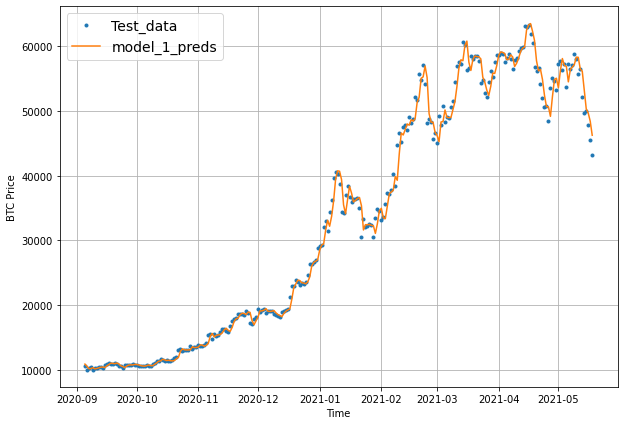

In [43]:
# Visualizing the result

offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

### Model 2: Dense (window = 30, horizon = 1)

In [44]:
HORIZON = 1
WINDOW_SIZE = 30

In [45]:
# Make windowed data with appropriate horizon nad window size

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [46]:
# Make train and test windows

train_windows, test_windows, train_labels, test_labels = make_train_test_split(windows=full_windows,
                                                                               labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [47]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_2_dense")

# Compile model
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [48]:
# Evaluate model_2 preds

model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 633.7443


633.7443237304688

In [49]:
# Load in best performing model

model_2 = tf.keras.models.load_model("model_experiments/model_2_dense")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 608.0563


608.0562744140625

In [50]:
# Get forecast predictions

model_2_preds = make_preds(model_2,
                           input_data=test_windows)
model_2_preds[-10:]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([56999.13 , 57078.348, 58056.934, 56529.344, 56888.934, 52952.504,
       50854.074, 49465.266, 49118.69 , 45417.703], dtype=float32)>

In [51]:
# Evaluate results for model_2 prediction

model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)

In [52]:
model_2_results

{'mae': 608.0563,
 'mse': 1244325.1,
 'rmse': 1115.4933,
 'mape': 2.7472448,
 'mase': 1.0628884}

### Model 3: Dense (window = 30, horizon = 7)

In [53]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [54]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [55]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name = "model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [56]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1429.0547


1429.0546875

In [57]:
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1233.0946


1233.0946044921875

In [58]:
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[-5:]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[56252.05 , 56348.6  , 57367.215, 57298.49 , 56493.855, 56834.684,
        57712.4  ],
       [57108.52 , 57644.92 , 57279.812, 58053.28 , 58568.492, 58781.793,
        58228.594],
       [57938.65 , 57215.07 , 59811.285, 60468.945, 58845.984, 60907.598,
        59916.906],
       [57407.25 , 58884.47 , 59774.145, 60217.31 , 59855.65 , 60640.707,
        59986.06 ],
       [56543.85 , 56269.64 , 58090.63 , 57907.75 , 59224.633, 58248.73 ,
        58474.17 ]], dtype=float32)>

In [59]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([  756.7026  ,   489.8789  ,   334.90695 ,   540.6342  ,
          557.55426 ,   627.61053 ,   632.01953 ,   561.36975 ,
          547.3348  ,   609.5191  ,   791.5566  ,   808.8758  ,
          879.4336  ,   915.4212  ,   641.0532  ,   325.71158 ,
          171.52818 ,   173.96861 ,   203.69162 ,   225.41838 ,
          137.99086 ,   253.08936 ,   314.1613  ,   347.4866  ,
          158.03893 ,   117.72168 ,    89.68262 ,   156.85344 ,
          173.19295 ,   227.58684 ,   281.4822  ,   362.3185  ,
          367.24896 ,   317.32016 ,   360.89767 ,   320.05594 ,
          376.59976 ,   265.66058 ,   194.57004 ,   195.33447 ,
          433.77078 ,   103.90743 ,    64.58224 ,   115.01514 ,
          132.7006  ,   106.05392 ,    85.75697 ,   129.34535 ,
          151.93254 ,   146.81473 ,   182.58147 ,   139.22844 ,
          212.3256  ,   227.45193 ,   236.94287 ,   330.67062 ,
          541.0009  ,   460.84863 ,   436.2933  ,   472.1148  ,
          338.80746 ,   156.09221

### Make our evaluation function work for larger horizon

In [72]:
def evaluate_preds(y_true, y_pred):

  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [73]:
# Get model_3 reults

model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1233.0946,
 'mse': 5472064.5,
 'rmse': 1419.5555,
 'mape': 5.5898685,
 'mase': 2.194223}

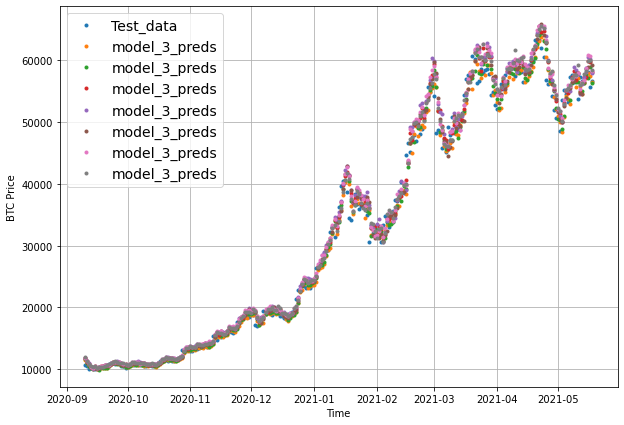

In [61]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

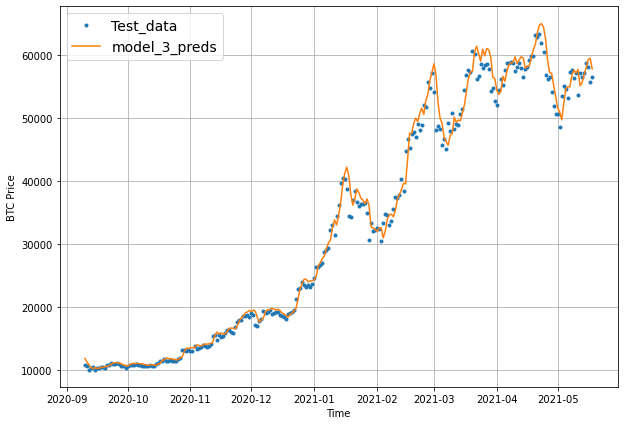

In [62]:
offset = 300
plt.figure(figsize=(10, 7))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), format="-", start=offset, label="model_3_preds")

### Which of our model is performing best so far?

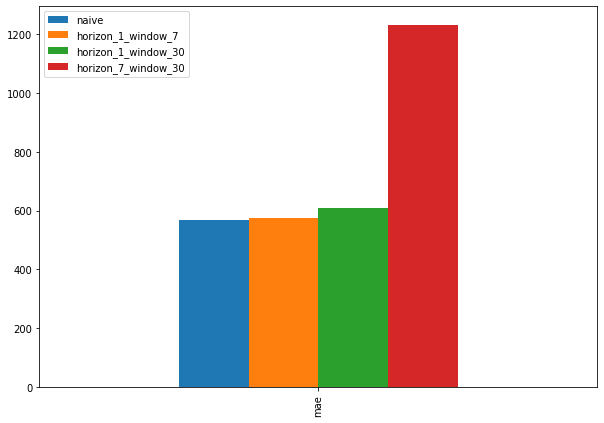

In [74]:
pd.DataFrame({"naive":naive_results["mae"],
              "horizon_1_window_7":model_1_results["mae"],
              "horizon_1_window_30":model_2_results["mae"],
              "horizon_7_window_30":model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

### Model 4: Conv1D

In [75]:
HORIZON = 1
WINDOW_SIZE = 7

In [76]:
# Create windowed dataset

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [77]:
# Create test/train splits

train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [78]:
# Check data sample shapes
train_windows[0].shape

(7,)

In [80]:
# Before we pass our data to conv1D, we have to reshape it to make sure it works

x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))
print(f"Original shape: {x.shape}")
print(f"Expanded shape: {expand_dims_layer(x).shape}")
print(f"Original values with Expanded shape:\n{expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with Expanded shape:
[[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [82]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
    layers.Dense(HORIZON)
], name="model_4_Conv1D")

model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_4.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [83]:
model_4.summary()

Model: "model_4_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_3 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [85]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_Conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 574.9383


574.9382934570312

In [86]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:5]

18/18 [==============================] - 0s 6ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8939.365, 8816.847, 9034.044, 8835.315, 8773.612], dtype=float32)>

In [88]:
# Evaluate predictions

model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 574.9383,
 'mse': 1200487.6,
 'rmse': 1095.6676,
 'mape': 2.581839,
 'mase': 1.0100074}